# Convergent Cross Mapping (CCM) Algorithm
#### Written by: SungJun Cho (scho20@uchicago.edu)
- Adapted mainly from **Sugihara et al. (2012)** and **McCracken & Weigel (2014)**. For the detailed outline of the CCM algortihm and its application to experimental data, I recommend reviewing these papers. See Appendix for the full list of references.
    - Sugihara G., May R., Ye H., Hsieh C., Deyle E., Fogarty M., Munch S. (2012) Detecting Causality in Complex Econsystems. Science, 338: 496-500.
    - McCracken J.M., Weigel R.S. (2014) Convergent Cross-Mapping and Pairwise Asymmetric Inference. Phys. Rev. E 90, 062903. arXiv: 1407.5696v1.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
from sklearn.neighbors import NearestNeighbors

#### 0. Set a pseudo-signal

In [30]:
def sine_gaussnoise(T, Fs, f, sigma):
    time = np.arange(T)
    noise = sigma * np.random.randn(T)
    signal = np.sin(2*np.pi*f*time/Fs) + noise
    return signal

T = 1000 # number of time points
Fs = 100 # sampling frequency
f = 2
sigma = 0.2 # noise factor

signal = sine_gaussnoise(T, Fs, f, sigma)

NOTE: Try generating a pseudo-signal by multiplying the noise instead of adding it, or by simply adding larger noise. Then, run Section A. If larger stochasticity is involved in the time series, larger time lag and embedding dimension are needed to provide an optimal analysis. For such reason, CCM is not designed to measure causality in purely stochastic signals (contrary to Granger Causality) and performs better with deterministic signals (cf. Sugihara et al., 2012). To apply CCM onto neural activities, you should make sure the noises are filtered out as much as possible before analyzing the signals.

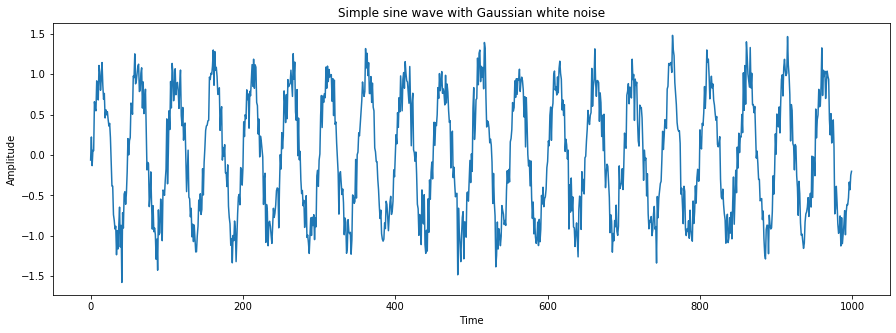

In [31]:
plt.figure(figsize=(15,5))
plt.plot(signal)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Simple sine wave with Gaussian white noise')
plt.show()

## Section A: Embedding Data to Shadow Manifolds

Please note that some codes were adpated and further developed from the references below:  
>Reference for A1 Method 1: [Code](https://github.com/nickc1/skccm) and [PDF](https://buildmedia.readthedocs.org/media/pdf/skccm/latest/skccm.pdf)  
Reference for A1 Method 2, A2, A3: [Introduction to Taken's Embedding](https://www.kaggle.com/tigurius/introduction-to-taken-s-embedding/data)

#### 1. Create a shadow manifold for the input data X
- Create a shadow manifold $\tilde{X}$. Given an embedding dimension $E$, the shadow manifold of $X$, called $\tilde{X}$, is created by associating an $E$-dimensional vector (also called a delay vector) to each point $X_t$ in $X$, i.e. $\tilde{X}=(X_t, X_{t-\tau}, X_{t-2\tau}, ..., X_{t-(E-1)\tau})$.
- Mathematically, the first vector is created at $t = 1+(E+1)\tau$, and the last vector is created at $t = L$ where $L$ denotes the number of points in the time series and is also called as the library length.

##### METHOD 1

In [32]:
def generate_shadow_manifold(signal, delay, dimension):
    sigsize = signal.shape[0]
    sig_iter = sigsize-(delay*(dimension-1))
    M = np.zeros((sig_iter, dimension))
    
    for i in range(sig_iter):
        end_val = i + delay*(dimension-1)+1
        point = signal[i:end_val]
        M[i,:] = point[::delay]

    return M

(998, 3)


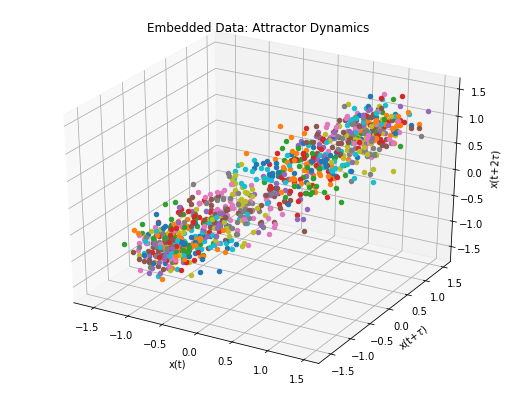

In [33]:
delay  = 1
dim = 3

Mx = generate_shadow_manifold(signal, delay, dim)
print(Mx.shape)

fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, projection='3d')
for i in range(len(Mx)):
    ax.scatter(Mx[i,0], Mx[i,1], Mx[i,2])
ax.set_title('Embedded Data: Attractor Dynamics')
ax.set_xlabel(r'x(t)')
ax.set_ylabel(r'x(t+$\tau$)')
ax.set_zlabel(r'x(t+$2\tau$)')
plt.show()

##### METHOD 2

In [34]:
# This function returns the Takens embedding of data with delay into dimension. delay * dimesion must be < len(data)

def TakensDelayEmbedding(signal, delay, dimension):
    if delay*dimension > len(signal):
        raise NameError('Delay times dimension exceed length of the input signal.')
    embeddedData = np.array([signal[0:len(signal)-delay*dimension]])
    for i in range(1, dimension):
        embeddedData = np.append(embeddedData, [signal[i*delay:len(signal) - delay*(dimension-i)]], axis=0)
    return embeddedData

(3, 997)


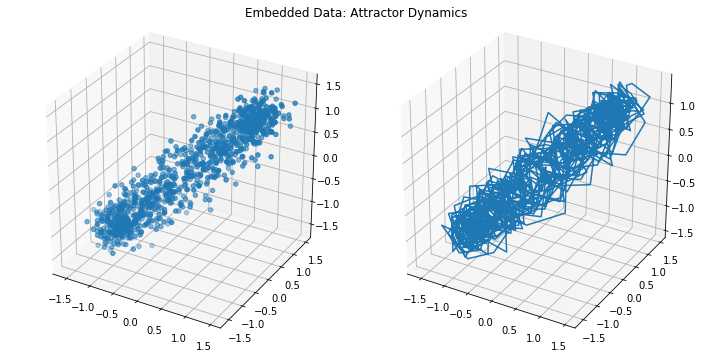

In [35]:
tau = 1
dim = 3

embSig = TakensDelayEmbedding(signal, tau, dim)
print(embSig.shape)

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(embSig[0,:], embSig[1,:], embSig[2,:]);
ax = fig.add_subplot(122, projection='3d')
ax.plot(embSig[0,:], embSig[1,:], embSig[2,:]);
plt.suptitle('Embedded Data: Attractor Dynamics')
plt.tight_layout()

plt.show()

Method 2 was used for all the subsequent analyses.

#### 2. The Mutual Information: Determining the Correct Delay Value

How do we choose parameters of the delay and dimension given that we do not know these a priori?

- Considering the embedding plots abvoe, the three-dimensional one looks farily deterministic. We can formalize this observation by adopting two measures which give us an insight about which delay and which dimension to choose.

The first measure, which is used to compute the optimal delay value, is the mutual information.
- First, we start by calculating the minimium  $x_{min}$  and maximum  $x_{max}$  of the time-series. Then the interval $[x_{min}, x_{max}]$ is divided into a large number of bins. Define $P_k$ as the probability that an element of the time-series is in the $k$-th bin. Likewise, define $P_{h,k(τ)}$ as the probability that $x_i$  is in the  $h$-th bin while $x_{i+τ}$  is in the  $k$-th bin. Using these terms, the mutual information can be defined as the following: $$I(τ) = −\Sigma_{h=1}^{nBins}\Sigma_{k=1}^{nBins}P_{h,k(τ)}log\frac{P_{h,k(τ)}}{P_hP_k}$$.
- The first minimum of  $I(τ)$  as a function of $\tau$ gives an optimal value for the delay, since there we get largest information by adding  $x_{i+τ}$ . All probabilities here are calculated as empirical probabilities.

In [36]:
# The function for calculating mutual information for a given delay value

def calc_MutualInformation(signal, delay, nBins, verbose):
    I = 0
    xmax = np.max(signal)
    xmin = np.min(signal)
    if verbose == 1:
        print('Minimum and maximum of the signal are: ', [xmin, xmax])
    
    signalDelay = signal[delay:len(signal)]
    signalOriginal = signal[0:len(signal)-delay]
    binsize = np.abs(xmax - xmin) / nBins
    if verbose == 1:
        print('Size of the bin is: ', (binsize))
    
    probInBin = {}
    conditionBin = {}
    conditionDelayBin = {}
    
    for h in range(0, nBins):
        if h not in probInBin:
            conditionBin.update({h : (signalOriginal >= (xmin+h*binsize)) & (signalOriginal < (xmin+(h+1)*binsize))})
            probInBin.update({h : len(signalOriginal[conditionBin[h]]) / len(signalOriginal)})
        for k in range(0, nBins):
            if k not in probInBin:
                conditionBin.update({k : (signalOriginal >= (xmin+k*binsize)) & (signalOriginal < (xmin+(k+1)*binsize))})
                probInBin.update({k : len(signalOriginal[conditionBin[k]]) / len(signalOriginal)})
            if k not in conditionDelayBin:
                conditionDelayBin.update({k : (signalDelay >= (xmin+k*binsize)) & (signalDelay < (xmin+(k+1)*binsize))})
            Phk = len(signalOriginal[conditionBin[h] & conditionDelayBin[k]]) / len(signalOriginal)
            if Phk != 0 and probInBin[h] != 0 and probInBin[k] != 0:
                I -= Phk * math.log(Phk / (probInBin[h]*probInBin[k]))

    return I

tau = 1
nBins = 10

I = calc_MutualInformation(signal, tau, nBins, verbose=1)
print('The mutual information given a delay of {} is: {}'.format(tau, I))

Minimum and maximum of the signal are:  [-1.5778847370139248, 1.4802524793378724]
Size of the bin is:  0.3058137216351797
The mutual information given a delay of 1 is: -0.8159197396486934


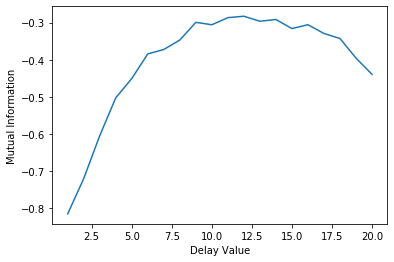

The optimal delay value for given time series is:  1


In [37]:
delay_vector = np.arange(1, 21)
info_vector = []

for i in delay_vector:
    info_vector = np.append(info_vector, [calc_MutualInformation(signal, i, nBins, verbose=0)])

plt.plot(delay_vector, info_vector)
plt.xlabel('Delay Value')
plt.ylabel('Mutual Information')
plt.show()

idx_minI = np.argmin(info_vector)
lag_opt = delay_vector[idx_minI] # optimal tau value
minI = np.min(info_vector)
if info_vector[idx_minI] != minI:
    raise ValueError('Incorrect delay value output.')
    
print('The optimal delay value for given time series is: ', lag_opt)

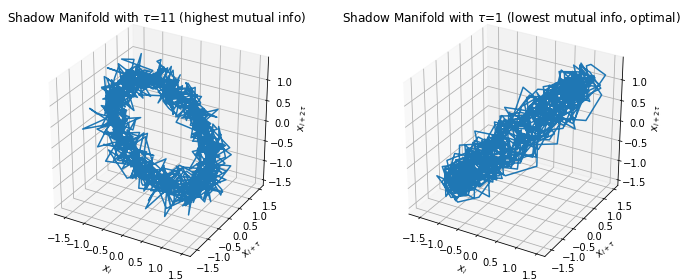

In [69]:
tau1 = np.argmax(info_vector)
tau2 = lag_opt
dim = 3

embSig1 = TakensDelayEmbedding(signal, tau1, dim)
embSig2 = TakensDelayEmbedding(signal, tau2, dim)

fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(121, projection='3d')
ax.plot(embSig1[0,:], embSig1[1,:], embSig1[2,:]);
ax.set_xlabel(r'$x_i$')
ax.set_ylabel(r'$x_{i+\tau}$')
ax.set_zlabel(r'$x_{i+2\tau}$')
ax.set_title(r'Shadow Manifold with $\tau$={} (highest mutual info)'.format(tau1))
ax = fig.add_subplot(122, projection='3d')
ax.plot(embSig2[0,:], embSig2[1,:], embSig2[2,:]);
ax.set_xlabel(r'$x_i$')
ax.set_ylabel(r'$x_{i+\tau}$')
ax.set_zlabel(r'$x_{i+2\tau}$')
ax.set_title(r'Shadow Manifold with $\tau$={} (lowest mutual info, optimal)'.format(tau2))
plt.tight_layout()

plt.show()

#### 3. Find the false nearest neighbor: Determine the Correct Dimension

The second measure, which is used to compute the best dimension is called a false nearest neighbor (FNN).  
See also: [Wikipedia page](https://en.wikipedia.org/wiki/False_nearest_neighbor_algorithm)

- Here, we will use false nearest neighbors as the measures to determine correct embedding dimension, $E$. False nearest neighbors rely on the assumption that unfolding a deterministic system (i.e. embedding it in subsequently higher dimensions) is smooth. That is, points which are close in one embedding dimension should be close in the next higher embedding dimension.

- To measure FNNs, we identify a point $p_i$ with a neighbor point $p_j$ and calculate the distance between these two points, i.e. $|| p_i - p_j || < \epsilon$ for some $\epsilon > 0$. Then, we look at the noramlized distance $$R_i = \frac{|x_{i+d\tau}-x_{j+d\tau}|}{||p_i-p_j||}$$ where $d$ signifies dimension and $\tau$ signifies delay (i.e. lag).

- Based on the normalized distance, we can calculate the number of FNNs, which are the points that satisfy the condition $R_i > R_{thr}$ where $R_{thr} = 10$.

- Then, we compare the number of FNNs for different embedding dimension. The appropriate embedding dimension can be determined when the number of FNNs is relatively small.

In [39]:
def computeFNN(signal, delay, dimension, R_thr=10):
    embSig = TakensDelayEmbedding(signal, delay, dimension)
    nbr = NearestNeighbors(n_neighbors=2, algorithm='auto').fit(embSig.transpose())
    # Note: The first neareste neighbor, n_neighbors=1, is the data point itself.
    distance, index = nbr.kneighbors(embSig.transpose())
    epsilon = np.std(distance.flatten())
    distDiff = np.diff(distance)
    nFNN = 0
    for i in range(0, len(signal)-delay*(dimension+1)):
        R = abs(signal[i+dimension*delay] - signal[index[i,1]+dimension*delay]) / distance[i,1] # normalized distance
        if (0 < distDiff[i+1]) and (distDiff[i+1] < epsilon) and (R > R_thr):
        # or alternatively, if (0 < dist[i+1, 1]) and (distDiff[i+1, 1] < epsilon) and (R > R_thr):
            nFNN += 1

    return nFNN

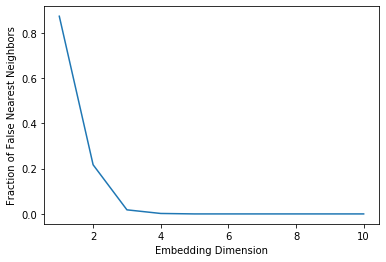

The optimal embedding dimension value is:  5


In [40]:
tau = lag_opt
dim_range = np.arange(1, 11)
num_FNN = []

for i in dim_range:
    num_FNN = np.append(num_FNN, [computeFNN(signal, tau, i)])

frac_FNN = num_FNN / len(signal)
plt.plot(dim_range, frac_FNN)
plt.xlabel('Embedding Dimension')
plt.ylabel('Fraction of False Nearest Neighbors')
plt.show()

idx_minDim = np.argmin(num_FNN)
dim_opt = dim_range[idx_minDim] # optimal embedding dimension
minDim = np.min(num_FNN)

if num_FNN[idx_minDim] != minDim:
    raise ValueError('Incorrect FNN output.')

print('The optimal embedding dimension value is: ', dim_opt)

In [41]:
from matplotlib.collections import PolyCollection
from matplotlib import colors as mcolors

embSig_FINAL = TakensDelayEmbedding(signal, lag_opt, dim_opt)
print(embSig_FINAL.shape)

L = np.shape(embSig_FINAL)[1]
embTime = np.arange(float(L))

S = []

for i in range(dim_opt):
    S.append([*zip(embTime, embSig_FINAL[i,:])])

(5, 995)


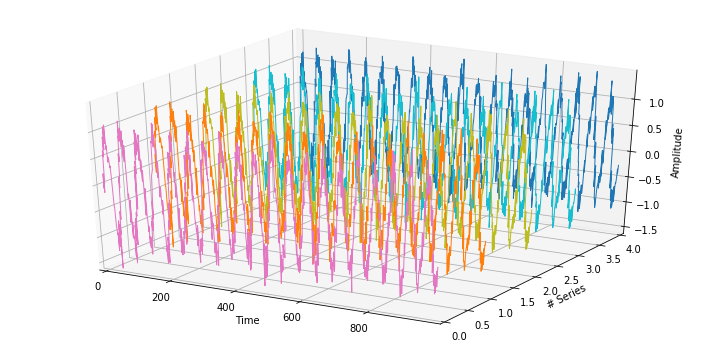

In [42]:
def cc(arg):
    # Shorthand to convert 'named' colors to rgba format at 0% opacity (transparent)
    return mcolors.to_rgba(arg, alpha=0)

def find_maxmin_amp(S, dim_opt):
    maxamp = np.zeros((dim_opt,1))
    minamp = np.zeros((dim_opt,1))
    for i in range(dim_opt):
        S_sepdim = S[i] # 3d list separated by dimensional aspect
        S_amp = [x[1] for x in S_sepdim]
        maxamp[i] = max(S_amp)
        minamp[i] = min(S_amp)
    Amax = max(maxamp)
    Amin = min(minamp)
    return Amax, Amin

zlim_up, zlim_down = find_maxmin_amp(S, dim_opt)

fig = plt.figure(figsize=(10, 5))
ax = fig.gca(projection='3d') # get the current axes, or create one if necessary
poly = PolyCollection(S, closed=False, edgecolors=['tab:pink','tab:orange','tab:olive','tab:cyan', 'tab:blue'], facecolors=cc('white'))
ax.add_collection3d(poly, zs=range(dim_opt), zdir='y')
ax.set_xlim(0, L)
ax.set_ylim(0, dim_opt-1)
ax.set_zlim(zlim_down, zlim_up)
ax.set_xlabel('Time')
ax.set_ylabel('# Series')
ax.set_zlabel('Amplitude')
plt.tight_layout()
plt.show()

# For alternative method of plotting the time series, refer to:
# https://stackoverflow.com/questions/34099518/plotting-a-series-of-2d-plots-projected-in-3d-in-a-perspectival-way

I recommend going through [Advanced Visualization for Data Scientists with Matplotlib](https://medium.com/sfu-cspmp/advanced-visualization-for-data-scientists-with-matplotlib-15c28863c41c) if you want to become more familiar with the matplotlib package on python.

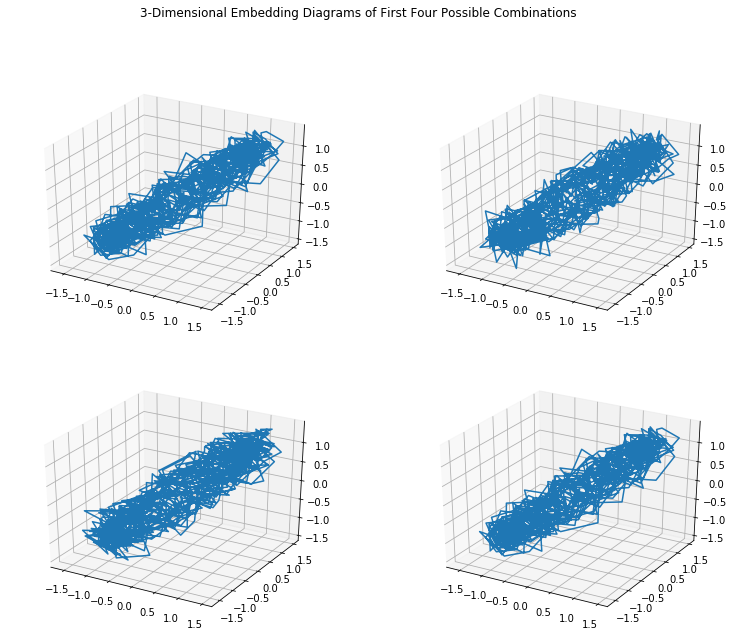

In [65]:
fig = plt.figure(figsize=(13,10))
ax = fig.add_subplot(2, 2, 1, projection='3d')
ax.plot(embSig_FINAL[0,:], embSig_FINAL[1,:], embSig_FINAL[2,:])
ax = fig.add_subplot(2, 2, 2, projection='3d')
ax.plot(embSig_FINAL[0,:], embSig_FINAL[1,:], embSig_FINAL[3,:])
ax = fig.add_subplot(2, 2, 3, projection='3d')
ax.plot(embSig_FINAL[0,:], embSig_FINAL[2,:], embSig_FINAL[3,:])
ax = fig.add_subplot(2, 2, 4, projection='3d')
ax.plot(embSig_FINAL[1,:], embSig_FINAL[2,:], embSig_FINAL[3,:])
plt.suptitle('3-Dimensional Embedding Diagrams of First Four Possible Combinations')
plt.show()

## Section B: Implementing CCM Algorithm

#### 0. Set pseudo-signals

Now that we know how to correctly embed data onto its shadow manifold, let's start implementing CCM algorithm. Since we want to measure the causality between two signals, we can simply generate two sine waves.

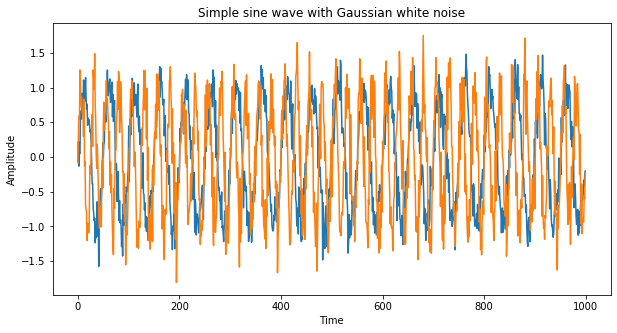

In [44]:
def sine_gaussnoise(T, Fs, f, sigma):
    time = np.arange(T)
    noise = sigma * np.random.randn(T)
    signal = np.sin(2*np.pi*f*time/Fs) + noise
    return signal

T = 1000
Fs = 100
f = 4
sigma = 0.3

X = signal
Y = sine_gaussnoise(T, Fs, f, sigma)

plt.figure(figsize=(10,5))
plt.plot(np.arange(T), X)
plt.plot(np.arange(T), Y)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Simple sine wave with Gaussian white noise')
plt.show()

However, to keep the simplicity and clarity of the example, we will use coupled logitic equations for the subsequent sections, because these equations produce nonlinear, deterministic time series. The equations and their parameter values are taken from Sugihara et al., 2012.

> Coupled difference equations exhibit chaotic behavior and are as follows:
$$X(t+1) = X(t)[r_x-r_xX(t)-\beta_{x,y}Y(t)]$$
$$Y(t+1) = Y(t)[r_y-r_yY(t)-\beta_{y,x}X(t)]$$

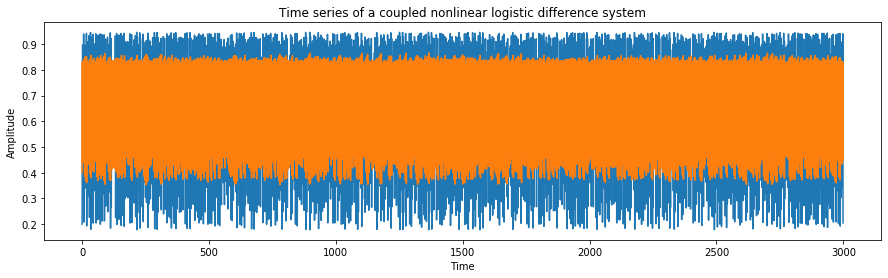

In [45]:
def coupled_logistic_fn(x0, y0, rx, ry, beta_xy, beta_yx, iteration):
    x = np.zeros((iteration,))
    y = np.zeros((iteration,))
    
    x[0] = x0
    y[0] = y0
    
    for i in range(iteration-1):
        x[i+1] = x[i]*(rx - rx*x[i] - beta_xy*y[i])
        y[i+1] = y[i]*(ry - ry*y[i] - beta_yx*x[i])
     
    # To add stochasticity:
    # x = x + np.random.randn(iteration)
    # y = y + np.random.randn(iteration)
    
    return x, y

iteration = 3000
x_init = 0.2; y_init = 0.4

X, Y = coupled_logistic_fn(x_init, y_init, 3.8, 3.5, 0.02, 0.1, iteration)

plt.figure(figsize=(15, 4))
plt.plot(np.arange(iteration), X)
plt.plot(np.arange(iteration), Y)
plt.title('Time series of a coupled nonlinear logistic difference system')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

NOTE: Compare the results of CCM by changing iteration to 1000 instead of 3000. As the umber of points of the signals decreases, the Pearson's and CCM correlation coefficient values get relatively unreliable.

#### 1. Determine the delay and dimension values for data embedding

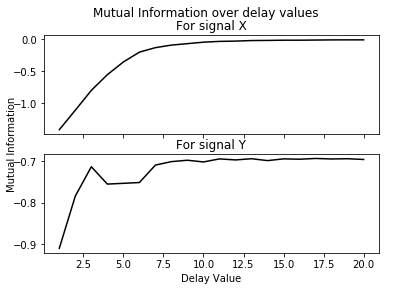

The optimal delay value for Mx and My is:  1


In [62]:
def find_lag_opt(nDelay, signalX, signalY, nBins, verbose=0, plot_yn=1):
    nDelay = nDelay+1
    delay_vector = np.arange(1, nDelay)
    info_vectorX = []
    info_vectorY = []
    
    for i in delay_vector:
        info_vectorX = np.append(info_vectorX, [calc_MutualInformation(signalX, i, nBins, verbose=verbose)])
        info_vectorY = np.append(info_vectorY, [calc_MutualInformation(signalY, i, nBins, verbose=verbose)])
        
    if plot_yn == 1:
        fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
        fig.add_subplot(111, frameon=False)
        plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
        plt.grid(False)
        ax[0].plot(delay_vector, info_vectorX, 'k')
        ax[0].set_title('For signal X')
        ax[1].plot(delay_vector, info_vectorY, 'k')
        ax[1].set_title('For signal Y')
        fig.suptitle('Mutual Information over delay values')
        plt.xlabel('Delay Value')
        plt.ylabel('Mutual Information')
        plt.show()
    
    idx_minI_X = np.argmin(info_vectorX)
    idx_minI_Y = np.argmin(info_vectorY)
    
    lag_optX = delay_vector[idx_minI_X]
    lag_optY = delay_vector[idx_minI_Y]
    
    return lag_optX, lag_optY

nDelay = 20
nBins = 10

tauX, tauY = find_lag_opt(nDelay, X, Y, nBins)

# IMPORTANT -- Need to decide based on the plot!
tau_final = tauX
print('The optimal delay value for Mx and My is: ', tau_final)

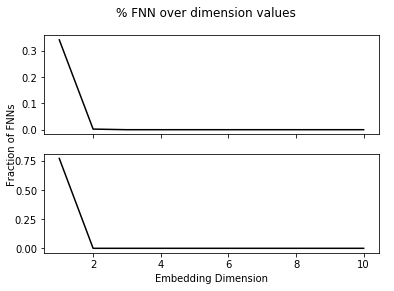

The optimal embedding dimension for Mx and My is:  3


In [64]:
def find_dim_opt(nDim, signalX, signalY, tauX, tauY, plot_yn=1):
    dim_range = np.arange(1, nDim+1)
    num_FNN_X = []
    num_FNN_Y = []
    
    for i in dim_range:
        num_FNN_X = np.append(num_FNN_X, [computeFNN(signalX, tauX, i)])
        num_FNN_Y = np.append(num_FNN_Y, [computeFNN(signalY, tauY, i)])
    
    if plot_yn == 1:
        frac_FNN_X = num_FNN_X / len(signalX)
        frac_FNN_Y = num_FNN_Y / len(signalY)
        fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
        fig.add_subplot(111, frameon=False)
        plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
        plt.grid(False)
        ax[0].plot(dim_range, frac_FNN_X, 'k')
        ax[1].plot(dim_range, frac_FNN_Y, 'k')
        fig.suptitle('% FNN over dimension values')
        plt.xlabel('Embedding Dimension')
        plt.ylabel('Fraction of FNNs')
        plt.show()
        plt.show()
        
    idx_minDim_X = np.argmin(num_FNN_X)
    idx_minDim_Y = np.argmin(num_FNN_Y)
    
    dim_optX = dim_range[idx_minDim_X]
    dim_optY = dim_range[idx_minDim_Y]
    
    return dim_optX, dim_optY

nDim = 10
dim_optX, dim_optY = find_dim_opt(nDim, X, Y, tauX, tauY)

# Two shadow manifolds should have same embedding dimension.
if dim_optX != dim_optY:
    dim_final = max(dim_optX, dim_optY)
    print('The optimal embedding dimension for Mx and My is: ', dim_final)
else:
    dim_final = dim_optX
    print('The optimal embedding dimensions for Mx and My are identical: ', dim_final)

#### 2. Create shadow manifolds $M_X$ and $M_Y$

In [48]:
Mx = TakensDelayEmbedding(X, tau_final, dim_final)
My = TakensDelayEmbedding(Y, tau_final, dim_final)

Mx = Mx.transpose()
My = My.transpose()

#### 3. Function for weight values

Given that $i = 1...E+1$, the weights are defined as $$w_i=\frac{u_i}{N}$$ where $u_i=e^{-d_i/d_1}$ and $N=\Sigma_{j=1}^{E+1}u_j$. Here, N is the normalization factor.

In [49]:
def create_weights(dist, testsize):
    W = [] # weights
    for i in range(testsize):
        u = np.exp((-dist[i])/dist[0])
        N = sum(u)
        w = u/N
        W.append(w)
    return W

#### 4. Find the nearest neighbors and cross-map estimates

- As noted by Sugihara et al. (2012) and McCracken & Weigel (2014), the minimum number of points needed for a bounding simplex in an E-dimensional space is $E+1$. Hence, for each point in the "library" of points in the attractor manifold (e.g. $M_X$), we need to find a set of $E+1$ nearest neighbors, which consist of a set of distances of neighbor points $\{d_1, d_2,..., d_{E+1}\}$ and a set of time indices $\{\hat t_1, \hat t_{2}, ..., \hat t_{E+1}\}$.
- Each distance is the Euclidean distance $D$ between two input vectors. For example, $d_i = D(X_{\hat t},X_{\hat t_i})$.
- With the computed weights and time indices, we can calcualte the cross-map estimates of $X$ and $Y$.
- A point $Y_t$ in $Y$ that is estimated from the shadow manifold $M_X$ is defined: $$\hat Y_t|M_X = \sum_{i=1}^{E+1}w_iY_{\hat t_i}$$
- A point $X_t$ in $X$ that is estimated from the shadow manifold $M_Y$ is defined: $$ \hat X_t|M_Y = \sum_{i=1}^{E+1}w_iX_{\hat t_i}$$
- To implement the computation outlined above, we use [KNearestNeighbors](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor.kneighbors) algorithm provided in the scikit learn package.

In [50]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(Mx,My)

from sklearn.neighbors import KNeighborsRegressor

if X_train.shape == Y_train.shape:
    E = X_train.shape[1]
    if E != dim_final:
        raise ValueError('Embedding dimension of the dataset is incorrect.')
    nNN = E + 1 # number of neigherest neighbors that must be found for each shadow manifold

knn_model1 = KNeighborsRegressor(nNN)
knn_model2 = KNeighborsRegressor(nNN)

X_pred = []
Y_pred = []

library_len = np.arange(10, len(X_train), len(X_train)/20, dtype='int')

if X_test.shape == Y_test.shape:
    testsize = X_test.shape[0]

for lib in library_len:
    knn_model1.fit(X_train[:lib], X_train[:lib])
    knn_model2.fit(Y_train[:lib], Y_train[:lib])
    
    distX, timeindX = knn_model1.kneighbors(X_test)
    distY, timeindY = knn_model2.kneighbors(Y_test)
    
    WX = create_weights(distX, testsize)
    WY = create_weights(distY, testsize)
    
    X_My = np.zeros((X_test.shape[0], E))
    Y_Mx = np.zeros((Y_test.shape[0], E))
    
    for k in range(E):
        X_My[:,k] = np.sum(WY * X_train[timeindY, k], axis=1) # Prediction of X based on the shadow manifold of Y
        Y_Mx[:,k] = np.sum(WX * Y_train[timeindX, k], axis=1) # Prediction of Y based on the shadow manifold of X
    
    X_pred.append(X_My)
    Y_pred.append(Y_Mx)

#### 5. Compute the Pearson's correlation coefficient

In [51]:
from scipy.stats import pearsonr

Rx = np.zeros((E,))
Ry = np.zeros((E,))
Px_val = np.zeros((E,))
Py_val = np.zeros((E,))

RX_lib = []
RY_lib = []

for lib in range(len(library_len)):
    tempX_pred = X_pred[lib]
    tempY_pred = Y_pred[lib]
    
    for e in range(E):
        Rx[e], Px_val[e] = pearsonr(X_test[:,e], tempX_pred[:,e])
        Ry[e], Py_val[e] = pearsonr(Y_test[:,e], tempY_pred[:,e])
    
    RX = np.mean(Rx)
    RY = np.mean(Ry)
    
    RX_lib.append(RX)
    RY_lib.append(RY)

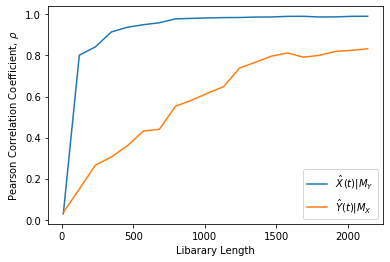

In [52]:
fig,ax = plt.subplots(nrows=1, ncols=1)
ax.plot(library_len, RX_lib, label=r'$\hatX(t)| M_Y$')
ax.plot(library_len, RY_lib, label=r'$\hatY(t)|M_X$')
ax.set_xlabel('Libarary Length')
ax.set_ylabel(r'Pearson Correlation Coefficient, $\rho$')
ax.legend()
plt.show()

From the plot above, we see the evidence of convergence for both $\hat X(t)|M_Y$ and $\hat Y(t)|M_X$ and can conclude that time series X and Y are coupled bidirectionally. (See Sugihara et al., 2012 for bidirectional and unidirectional coupling.) Because cross mapping of $X$ using $M_Y$ converges faster, it can be said that the effect of $X$ on $Y$ is stronger, consistent to our preset parameter values in which $\beta_{y,x} > \beta_{x,y}$.

#### 6. Compute the CCM correlation

- The CCM correlation is the squared Pearson correlation coefficient. Any pair of time seiries, $X$ and $Y$ will have two CCM correlations: $$C_{YX}=[\rho(Y,\hat Y|M_X)]^{2} \qquad C_{XY}=[\rho(X,\hat X|M_Y)]^{2}$$ where $C_{YX}$ are the squared Pearson correlation coefficients between the original time series $Y$ and an estiamte of $Y$ from its convergent cross-mapping with $X$ and between $X$ and $\hat X|M_Y$, respectively. (McCracken & Weigel, 2014)
- The difference between two CCM correlations $\Delta=C_{YX}-C_{XY}$ can be employed to determine the CCM causality. If $\Delta < 0)$, we can infer that X can be estimated better using Y than the case where Y can be estimated using X. (McCracken & Weigel, 2014)

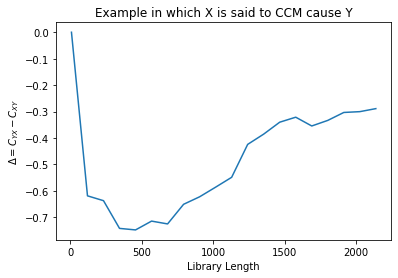

In [53]:
C_XY_lib = np.square(RX_lib) 
C_YX_lib = np.square(RY_lib)
C_diff = C_YX_lib - C_XY_lib

plt.plot(library_len, C_diff)
plt.xlabel('Library Length')
plt.ylabel(r'$\Delta=C_{YX}-C_{XY}$')
plt.title('Example in which X is said to CCM cause Y')
plt.show()

The graphs above show that X can be estimated better using Y than Y can be estimated using X (i.e. $\Delta < 0$). In this case, we say X "CCM cause" Y.  

Why do $\Delta$ decrease and then increase with the library length (i.e. nonmonotonic)? Just simply refer back to the plot above.

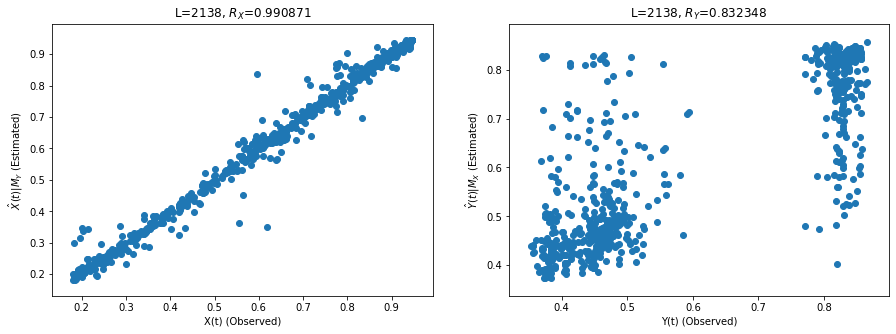

In [54]:
PRED_X = X_pred[-1][:,1]
OBS_X = X_test[:,1]

PRED_Y = Y_pred[-1][:,1]
OBS_Y = Y_test[:,1]

lib_select = library_len[-1]
RX_here = RX_lib[-1]
RY_here = RY_lib[-1]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

ax[0].scatter(OBS_X, PRED_X)
ax[0].set_xlabel('X(t) (Observed)')
ax[0].set_ylabel(r'$\hatX(t)|M_Y$ (Estimated)')
ax[0].set_title(r'L={}, $R_X$={:4f}'.format(lib_select,RX_here))

ax[1].scatter(OBS_Y, PRED_Y)
ax[1].set_xlabel('Y(t) (Observed)')
ax[1].set_ylabel(r'$\hatY(t)|M_X$ (Estimated)')
ax[1].set_title(r'L={}, $R_Y$={:4f}'.format(lib_select,RY_here))
plt.show()

## Appendix: Complete List of References and Additional Resources

References marked by $\dagger$ indicates that they were adapted either directly or indirectly in the script above.

**Papers**  
[1]$\dagger$ Sugihara G., May R., Ye H., Hsieh C., Deyle E., Fogarty M., Munch S. (2012) Detecting Causality in Complex Econsystems. Science, 338: 496-500.  
[2]$\dagger$ McCracken J.M., Weigel R.S. (2014) Convergent Cross-Mapping and Pairwise Asymmetric Inference. Phys. Rev. E 90, 062903. arXiv: 1407.5696v1.  
[3] Mønster D., Rusaroli R., Tylén K., Roepstorff A., Sherson J.F. (2017). Causal inference from noisy time-series data — Testing the Convergent Cross-Mapping algorithm in the presence of noise and external influence. Future Gener. Comput. Syst., 73: 52-62.  
[4] Benkő Z., Moldován K., Szádeczky-Kardoss K., Zalányi L., Borbély S., Világi I., Somogyvári Z. (2019). Causal relationship between local field potential and intrinsic optical signal in epileptiform activity in vitro. Scientific Reports, 9: 5171.  
[5] Schiecke K., Pester B., Feucht M., Leistritz L., Witte H. (2015). Convergent Cross Mapping: Basic Concept, Influence of Estimation Parameters and Practical Application. 2015 37th Annual International Conference of the IEEE Engineering in Medicine and Biology Society (EMBC), Milan, 7418-7421.

**Websites**  
[1]$\dagger$ https://www.kaggle.com/tigurius/introduction-to-taken-s-embedding/data  
[2]$\dagger$ https://buildmedia.readthedocs.org/media/pdf/skccm/latest/skccm.pdf

**Other CCM codes online**  
[1]$\dagger$ https://pypi.org/project/pyccm/#description (Python, Copyright (c) Frederic Laliberte, Univerity of Toronto by BSD License)  
[2]$\dagger$ https://github.com/nickc1/skccm (Python, Copyright (c) 2015 Ariel Rokem, The University of Washington eScience Institute by MIT License)  
[3] https://www.mathworks.com/matlabcentral/fileexchange/52964-convergent-cross-mapping (MATLAB)  
[4] https://github.com/danm0nster/xmap (MATLAB, Copyright (c) 2013, Dan Mønster by ISC License)  
[5] https://github.com/cjbayesian/rccm (R, Copyright (C) 2013  Corey Chivers by GNU General Public License)  
[6] https://github.com/SugiharaLab/pyEDM (Copyright 2019 The Regents of the University of California)
